# Resampling for Model Validation

In [55]:
suppressPackageStartupMessages({
  library(knitr)
  library(readr)
  library(ggplot2)
  library(tidyverse)
  library(car)
  library(caret)
  library(pscl)
  library(boot)
})

### Objective
As public figures from film and television have increasingly  transitioned to political careers in various levels of government. This trend raises questions as to what attributes contribute to an actor's electoral success. Career longevity, accolades, acting credits, and family connections may further enhance an actor's publicity and increase perceived credinility.

This study aims to apply bootstrap and jackknife resampling techniques to identify if career length (in years), number of acting credits, number of awards, and number of immediate family members in politiics are significantly associated with actors becoming elected politicians.Logistic regression modeling will be used to estimate the strength and direction these predictors while assessing model stability under resampling.

In [56]:
actors <- read_csv("https://raw.githubusercontent.com/zkdlyn/APM1210_SA2/refs/heads/main/celebrity_sample30.csv",
show_col_types = FALSE)

head(actors,5)

name,years_active,imdb_credits,family,education,politics,wins
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sam Milby,20,60,0,0,0,0
Daniel Padilla,15,34,1,0,0,1
Nadine Lustre,24,47,0,1,0,5
Bea Alonzo,23,51,0,1,0,0
Alden Richards,14,55,0,1,0,0


In [57]:
summary(actors)

     name            years_active   imdb_credits        family      
 Length:30          Min.   :13.0   Min.   : 15.00   Min.   :0.0000  
 Class :character   1st Qu.:21.5   1st Qu.: 47.50   1st Qu.:0.0000  
 Mode  :character   Median :29.0   Median : 59.50   Median :0.5000  
                    Mean   :30.9   Mean   : 69.00   Mean   :0.8667  
                    3rd Qu.:39.0   3rd Qu.: 85.75   3rd Qu.:1.0000  
                    Max.   :54.0   Max.   :151.00   Max.   :4.0000  
   education        politics        wins      
 Min.   :0.000   Min.   :0.0   Min.   :0.000  
 1st Qu.:1.000   1st Qu.:0.0   1st Qu.:0.000  
 Median :2.000   Median :0.0   Median :0.000  
 Mean   :1.733   Mean   :0.4   Mean   :1.433  
 3rd Qu.:2.000   3rd Qu.:1.0   3rd Qu.:2.000  
 Max.   :3.000   Max.   :1.0   Max.   :9.000  

**Initial Logistic Regression Model**

$$
ln \frac{p}{1-p}= \beta_0 + \beta_1 \cdot (\text{years\_active}) + \beta_2 \cdot (\text{imdb\_credits}) + \beta_3 \cdot (\text{family}) + \beta_4 \cdot (\text{wins})

$$

This formula models the log-odds of an actor becoming an elected politician as a linear combination of four predictors:  years_active, imdb_credits, family and wins.

In [58]:
logit <- glm(politics~ years_active + imdb_credits + family+wins, 
             data = actors, family = binomial)
summary(logit)


Call:
glm(formula = politics ~ years_active + imdb_credits + family + 
    wins, family = binomial, data = actors)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -2.46436    1.78997  -1.377   0.1686  
years_active  0.13991    0.07600   1.841   0.0656 .
imdb_credits -0.03640    0.02422  -1.503   0.1328  
family        1.33552    0.66190   2.018   0.0436 *
wins         -1.03659    0.65870  -1.574   0.1156  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 40.381  on 29  degrees of freedom
Residual deviance: 23.383  on 25  degrees of freedom
AIC: 33.383

Number of Fisher Scoring iterations: 6


The model reported that family (b=1.336, p=0.044) is a statistically significant predictor while years_active (b =0.140, p 0.066) is marginally significant. These predictors are both positively associated with the target variable with family having a greater effect. The other predictors, wins (b=-1.037, p=0.116) and imdb_credits (b=-0.036, p =0.133) had greater negative effects but did not reach statistical significance.

years_active imdb_credits       family         wins 
    2.066254     1.591245     1.927919     2.301049

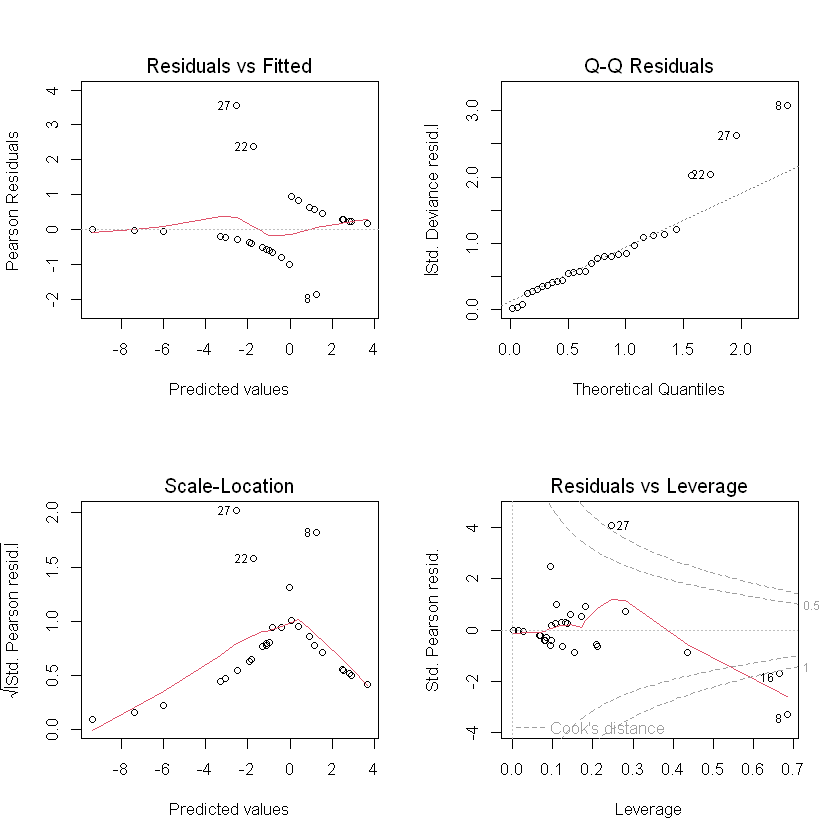

In [59]:
par(mfrow=c(2,2))
plot(logit)
vif(logit)

In [60]:
actors_x <- actors[-c(27),]

logit_2 <- glm(politics~ years_active + imdb_credits + family+wins, 
             data = actors_x, family = binomial)
summary(logit_2)



Call:
glm(formula = politics ~ years_active + imdb_credits + family + 
    wins, family = binomial, data = actors_x)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept)  -2.17335    3.06756  -0.708   0.4786  
years_active  0.30832    0.15526   1.986   0.0470 *
imdb_credits -0.11986    0.05326  -2.251   0.0244 *
family        2.75401    1.49980   1.836   0.0663 .
wins         -3.18660    1.87421  -1.700   0.0891 .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 38.496  on 28  degrees of freedom
Residual deviance: 12.570  on 24  degrees of freedom
AIC: 22.57

Number of Fisher Scoring iterations: 8


years_active imdb_credits       family         wins 
    2.301528     3.542583     7.378947     5.807987

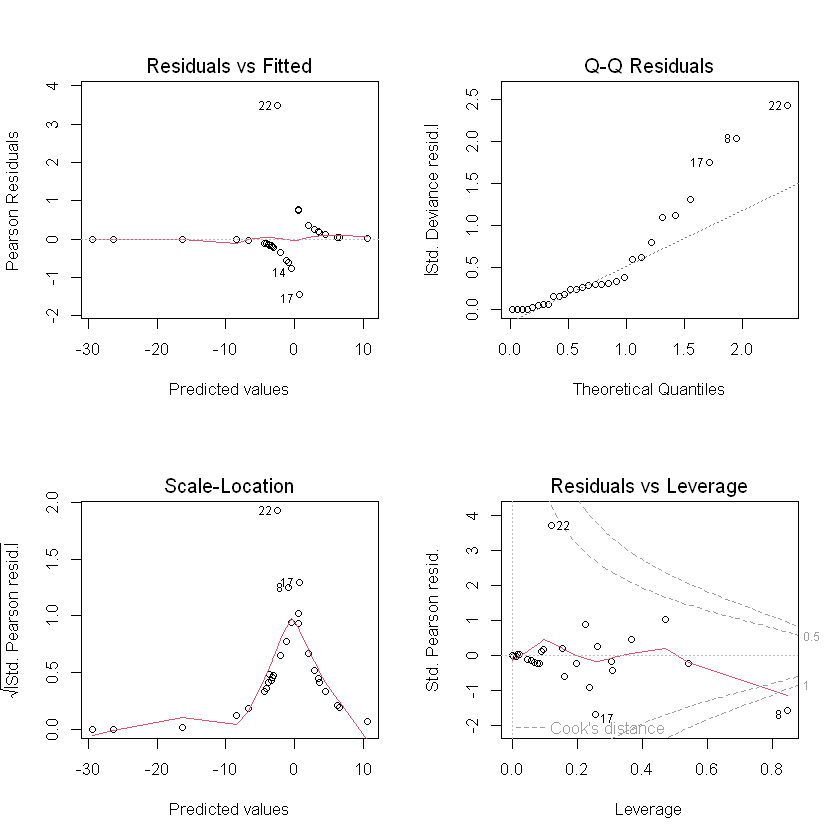

In [61]:
par(mfrow = c(2, 2))
plot(logit_2)
vif(logit_2)

### Bootstrap Resampling to Validate Model Performance

In [ ]:
    bootstrap_metrics <- function(data, formula, B = 1000) {
        n <- nrow(data)
        accuracies <- numeric(B)
        precisions <- numeric(B)
        recalls <- numeric(B)
        f1_scores <- numeric(B)
        
        for (b in 1:B) {
            i <- sample(1:n, size = n, replace = TRUE)
            sample.bs <- data[i, ]
            # fit logistic regression model on bootstrap sample
            logit.bs <- suppressWarnings(glm(formula, data = sample.bs, family = binomial))
            # test on original data
            prob <- predict(logit.bs, newdata = data, type = "response")
            pred <- ifelse(prob > 0.5, 1, 0)
            
            actual <- data[[as.character(formula[[2]])]]
            
            # calculate performance metrics
            accuracies[b] <- mean(pred == actual)
            true_positives <- sum(pred == 1 & actual == 1)
            predicted_positives <- sum(pred == 1)
            precisions[b] <- ifelse(predicted_positives == 0, NA, true_positives / predicted_positives)
            
            actual_positives <- sum(actual == 1)
            recalls[b] <- ifelse(actual_positives == 0, NA, true_positives / actual_positives)
            
            f1_scores[b] <- ifelse(is.na(precisions[b]) | is.na(recalls[b]) | (precisions[b] + recalls[b]) == 0,
                                                        NA,
                                                        2 * (precisions[b] * recalls[b]) / (precisions[b] + recalls[b]))
        }
    par(mfrow = c(2, 2))

    hist(accuracies, main = "Accuracy Distribution", xlab = "Accuracy", col = "skyblue", border = "white")
    hist(precisions, main = "Precision Distribution", xlab = "Precision", col = "salmon", border = "white")
    hist(recalls, main = "Recall Distribution", xlab = "Recall", col = "yellow", border = "white")
    hist(f1_scores, main = "F1 Score Distribution", xlab = "F1 Score", col = "orchid", border = "white")
    return(list((data.frame(
        accuracy = mean(accuracies, na.rm = TRUE),
        precision = mean(precisions, na.rm = TRUE),
        recall = mean(recalls, na.rm = TRUE),
        f1_score = mean(f1_scores, na.rm = TRUE)
    ))))
    
}

This code implements bootstrap resampling to evaluate the performance of logistic regression models. To validate the model's predictive capability, key classification metrics (accuracy, precision, recall, and F1 score) are estimated across 1000 resampled versions of the dataset.

In each iteration, a bootstrap sample is drawn from the original actors dataset by sampling with replacement. A logistic regression model is fitted to this bootstrap sample using years_active, imdb_credits, family, and wins as predictors. After training, the model is used to predict probabilities for the original dataset and converted into binary class predictions using a 0.5 threshold. Performance metrics are then computed by comparing these predictions against the actual target values from the original dataset.

Repeating this process 1000 times helps assess the reliability of the model and validating its predictive power within a limited pool of observations. 



|  accuracy| precision|    recall|  f1_score|
|---------:|---------:|---------:|---------:|
| 0.8481333| 0.8235926| 0.8080833| 0.8091622|

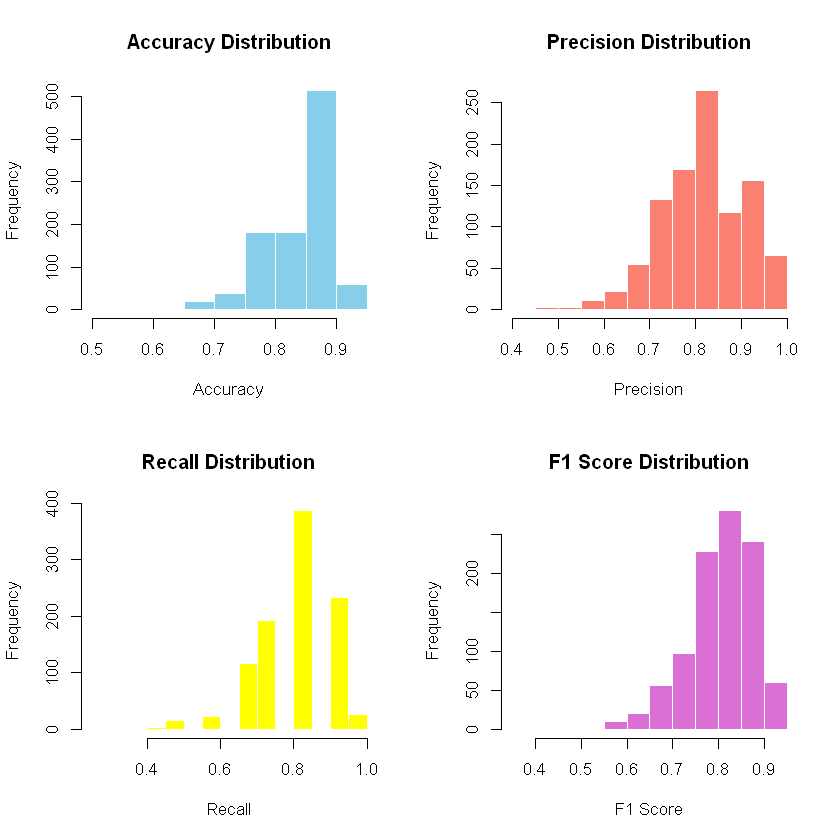

In [63]:
set.seed(124)
# using complete sample
results<-bootstrap_metrics(actors, politics ~ years_active + 
family + imdb_credits + wins, B = 1000)

kable(results)

The model correctly classifies approximately 84.8% of all cases, as indicated by the accuracy of 0.8481. When the model flags someone as an actor-politician, it is right 82.4% of the time. Of all the actual actors-politicians, the model identifies 80.8% of these cases correctly. The high F1 score of 0.8092 indicates a well-balanced performance, meaning the model maintains strong positive predictive value while still capturing a majority of true positives.



|  accuracy| precision|    recall|  f1_score|
|---------:|---------:|---------:|---------:|
| 0.8481333| 0.8235926| 0.8080833| 0.8091622|

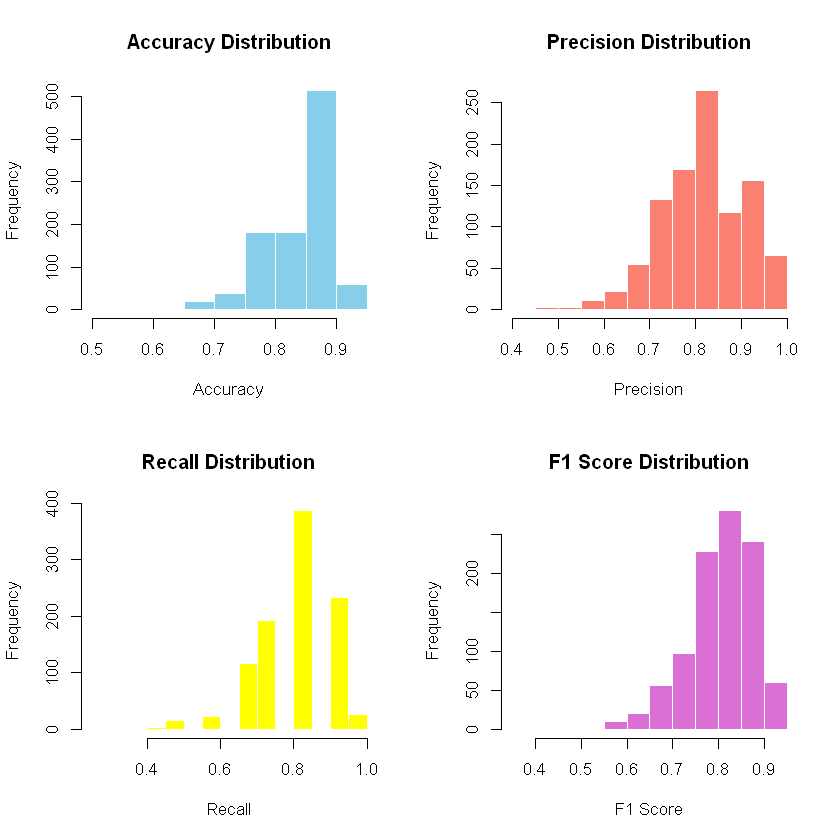

In [ ]:
set.seed(124)
# removed outlier
results<-bootstrap_metrics(actors, politics ~ years_active + 
family + imdb_credits + wins, B = 1000)

kable(results)



|  accuracy| precision|    recall|  f1_score|
|---------:|---------:|---------:|---------:|
| 0.8914138| 0.8620032| 0.8667273| 0.8585908|

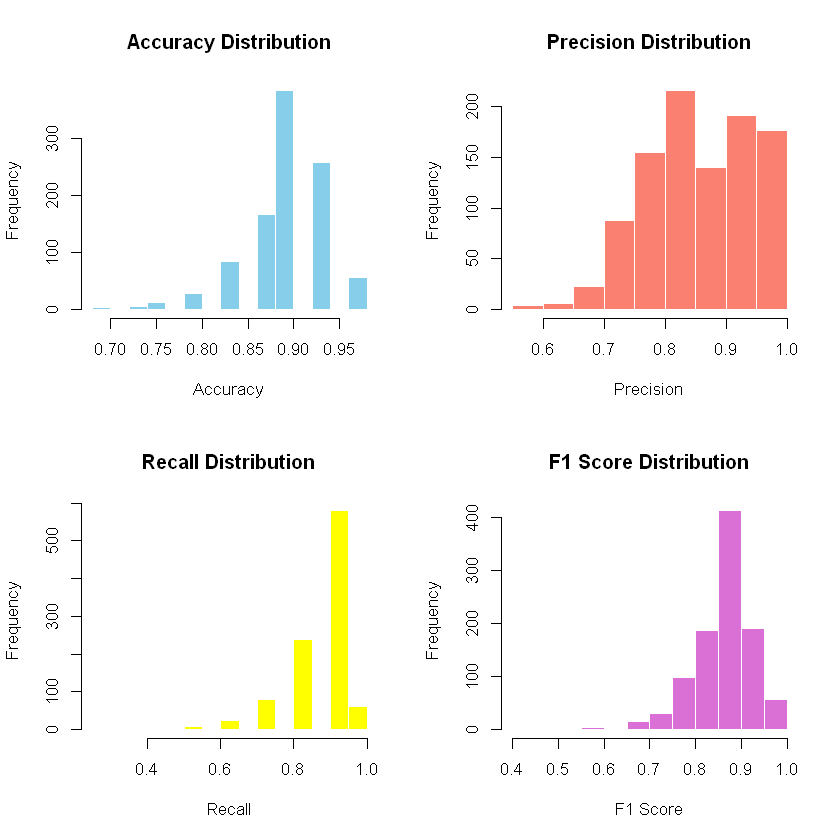

In [65]:
set.seed(124)
# using sample removed outliers
results<-bootstrap_metrics(actors_x, politics ~ years_active + 
family + imdb_credits + wins, B = 1000)

kable(results)